In [15]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, extensions
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-31 13:04:06,083: Credentials are already in use. The existing account in the session will be replaced.


Hamiltonian describes the situation in a physical system. For the sensing application we choose a Hamiltonian, $H= \sigma_{z}$. We will do the time evolution of our hamiltonian for pi/3 time.

In [16]:
circ = QuantumCircuit(2,2)
def matrix(qc):
    backend = Aer.get_backend('unitary_simulator')
    job =  execute(qc, backend)
    result = job.result()
    return result
circ.z(0)
circ.z(1)
mat = matrix(circ).get_unitary(circ, decimals= 3)
print(mat)


Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [-0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j],
          [-0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j],
          [ 0.-0.j,  0.-0.j,  0.-0.j,  1.-0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


Following cell wokr 

Instruction(name='hamiltonian', num_qubits=2, num_clbits=0, params=[array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j],
       [-0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j],
       [ 0.-0.j,  0.-0.j,  0.-0.j,  1.-0.j]]), 1.0471975511965976])


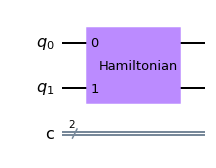

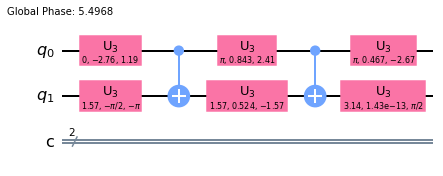

In [42]:
def hamilton(operator, time):
    gate = extensions.HamiltonianGate(operator, time)
    return gate

evolution = hamilton(mat, np.pi/3)
print(evolution)
#ham_gate = QuantumCircuit(2)
#ham_gate.unitary(evolution, [0,1])
circuit = QuantumCircuit(2,2)
circuit.append(evolution, [0, 1])
display(circuit.draw())

tran_ham = transpile(circuit, basis_gates=['cx','u3'])
display(tran_ham.draw())


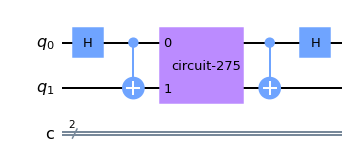

Traceback (most recent call last):
  Input In [47] in <cell line: 10>
    job = execute(bell, backend, shots = 1024)
  File /opt/conda/lib/python3.8/site-packages/qiskit/execute_function.py:294 in execute
    experiments = transpile(
  File /opt/conda/lib/python3.8/site-packages/qiskit/compiler/transpiler.py:335 in transpile
    circuits = parallel_map(_transpile_circuit, list(zip(circuits, transpile_args)))
  File /opt/conda/lib/python3.8/site-packages/qiskit/tools/parallel.py:132 in parallel_map
    return [task(values[0], *task_args, **task_kwargs)]
  File /opt/conda/lib/python3.8/site-packages/qiskit/compiler/transpiler.py:429 in _transpile_circuit
    result = pass_manager.run(
  File /opt/conda/lib/python3.8/site-packages/qiskit/transpiler/passmanager.py:218 in run
    return self._run_single_circuit(circuits, output_name, callback)
  File /opt/conda/lib/python3.8/site-packages/qiskit/transpiler/passmanager.py:273 in _run_single_circuit
    result = running_passmanager.run(circui

In [47]:
bell= QuantumCircuit(2,2)
bell.h(0)
bell.cx(0,1)
bell.append(tran_ham, [0,1])
bell.cx(0,1)
bell.h(0)
display(bell.draw())
bell.measure_all()
backend = Aer.get_backend('qasm_simulator')
job = execute(bell, backend, shots = 1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(bell)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)
